In [1]:
from utils import *

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [3]:
from tqdm import tqdm
import time
from scipy.special import logsumexp
from scipy.stats import multivariate_normal, multivariate_t, random_correlation
import yaml
import os
import imageio
import moviepy.editor as mp



In [4]:
# Load any settings
with open("settings.yaml", mode="r") as file:
    settings = yaml.safe_load(file)


In [7]:
np.random.seed(0)
D = 2
ddof_target = settings['ddof_target']
ddof_proposal = ddof_target

In [8]:
# Target
mean_target = np.zeros(D)
std_devs_target = np.diag(np.sqrt(np.ones(D)*2))
random_corr_mat = random_correlation(eigs=np.ones(D)).rvs(1)
cov_target =  std_devs_target @ random_corr_mat  @ std_devs_target
shape_target = ((ddof_target - 2) / ddof_target) * cov_target

# Proposal
mean_proposal = np.ones(D)
std_devs_proposal = np.diag(np.sqrt(np.ones(D)*6))
# random_corr_mat = random_correlation(eigs= np.ones(D)).rvs(1)
cov_proposal = std_devs_proposal @ random_corr_mat @ std_devs_proposal

shape_proposal = ((ddof_proposal - 2) / ddof_proposal) * cov_proposal

# AMIS

From : [https://ieeexplore.ieee.org/abstract/document/8902642?casa_token=gK_xJB2jt34AAAAA:65X9GElDk4_j4odWQmpPAp7nmEr7EXBzAFIwvgrqQdiCllmvO2ozoaF93Rs9t0tAg-2QvBEA_dw](here)

Note $\theta_j = (\mu_j, \Sigma_j)$

For $t=1,\dots,T$:

* Draw $M$ samples from the current proposal: $x_{t}^{(m)} \sim q(x, \theta_t), m=1,\dots,M$
* Weight the samples: $w_{\tau}^{(m)} = \frac{\pi(x_{\tau}^{(m)})}{(1/t) \sum_{j=1}^{t} q(x_{\tau}^{(m)}; \theta_{j})} $ for $\tau=1,\dots,t$ and $m=1,\dots,M$
* Normalize the weights: $\bar{w}_{\tau}^{(m)} = \frac{w_{\tau}^{(m)}}{\sum_{j=1}^{t} \sum_{m=1}^{M} w_{j}^{(m)}}$
* Update proposal parameters:
    * $\mu_{t+1} = \sum_{j=1}^{t} \sum_{m=1}^{M} \bar{w}_{j}^{(m)} x_{j}^{(m)}$
    * $\Sigma_{t+1} = \sum_{j=1}^{t} \sum_{m=1}^{M} \bar{w}_{j}^{(m)}  (x_{j}^{(m)} - \mu_{t+1})(x_{j}^{(m)} - \mu_{t+1})^\top $


In [9]:
def AMIS(mu_initial,shape_initial, n_iterations, target_pdf, ddof_proposal, M=200):
    all_normalized_logweights = np.empty((n_iterations,M))
    all_logweights = np.empty((n_iterations,M))
    all_samples = np.empty((n_iterations,M,D))
    evaluations_target_logpdf = np.empty((n_iterations,M))

    proposals_over_iterations = []

    # Iteration 0
    first_proposal = multivariate_t(loc=mu_initial,shape=shape_initial,df=ddof_proposal)
    proposals_over_iterations.append(first_proposal)
    samples_initial = first_proposal.rvs(size=M)
    all_samples[0,:] = samples_initial

    log_numerator = target_pdf.logpdf(samples_initial)
    evaluations_target_logpdf[0,:] = log_numerator

    log_denominator = first_proposal.logpdf(samples_initial) # No temporal mixture in iteration 0

    # assert log_numerator.shape == log_denominator.shape
    current_logweights = log_numerator - log_denominator
    all_logweights[0,:] = current_logweights
    all_normalized_logweights[0,:] = current_logweights - logsumexp(current_logweights)

    mu_current, shape_current = np.average(samples_initial, weights=np.exp(all_normalized_logweights[0,:]), axis=0), ((ddof_target - 2) / ddof_target) * np.cov(samples_initial, rowvar=False, aweights=np.exp(all_normalized_logweights[0,:]))

    # Zero-eth iteration is working

    assert mu_current.shape == (D,) and shape_current.shape == (D,D)

    # Iteration t > 0
    for t in tqdm(range(1,n_iterations)):

        current_proposal = multivariate_t(loc=mu_current, shape=shape_current, df=ddof_proposal)

        proposals_over_iterations.append(current_proposal)

        # Plot current proposal vs target
        plot_contour_lines(current_proposal, target_pdf, iteration=t)

        # Draw M samples from current proposal
        samples_current = current_proposal.rvs(size=M)
        all_samples[t,:] = samples_current # this adds to the existing list of samples, does not override

        # Weighting and re-weighting procedure

        # Numerator
        evaluations_target_logpdf[t,:] = target_pdf.logpdf(samples_current) # this adds to the existing list of target evaluations

        log_numerator = evaluations_target_logpdf[:t+1,:] # t+1 since including current ones !

        # Note the mixture in the denominator !

        def temporal_mixture(x):
            evaluations_mixture_component = np.empty((t+1,t+1,M))
            for tau in range(0,t+1):
                for j in range(0,t+1):
                    evaluations_mixture_component[tau,j,:] = proposals_over_iterations[j].logpdf(x[tau,:,:])

            # NOTE: Tried to vectorize as below but strangely gives different results... depends on what SciPy's .logpdf() does for 3 dimensional tensor x
            # vectorized_evaluations_mixture_component = np.asarray([ proposals_over_iterations[prev_t].logpdf(x) for prev_t in range(0,t+1) ])
            # assert np.allclose(vectorized_evaluations_mixture_component, evaluations_mixture_component)

            return logsumexp(evaluations_mixture_component,axis=1)

        mixture_denominator_evaluations = temporal_mixture(all_samples[:t+1,:,:])

        log_denominator = - np.log(t+1) +  mixture_denominator_evaluations  # check correct axis

        assert log_numerator.shape == log_denominator.shape

        assert all_logweights[:t+1,:].shape == log_numerator.shape

        updated_logweights = log_numerator - log_denominator
        all_logweights[:t+1,:] = updated_logweights # each iteration updates all weights up to time t

        updated_normalized_logweights = updated_logweights - logsumexp(updated_logweights)
        all_normalized_logweights[:t+1,:] = updated_normalized_logweights

        ### Update proposal
        # mu_current, shape_current = np.average(samples_current, weights=np.exp(current_normalized_logweights), axis=0), ((ddof_target - 2) / ddof_target) * np.cov(samples_current, rowvar=False, aweights=np.exp(current_normalized_logweights))

        samples_up_to_now = all_samples[:t+1,:,:]

        ## SLOW version for debugging:

        # mu_current = np.zeros(D)
        # for tau in range(t):
        #     for m in range(M):
        #         mu_current += np.exp(updated_normalized_logweights[tau, m]) * samples_up_to_now[t, m, :]
        #
        # shape_current = np.zeros((D, D))
        # for tau in range(t):
        #     for m in range(M):
        #         shape_current += np.exp(updated_normalized_logweights[tau, m]) * (samples_up_to_now[t, m, :].reshape(-1, 1) @ samples_up_to_now[t, m, :].reshape(1, -1))
        #
        # shape_current = ((ddof_target - 2) / ddof_target) * shape_current

        #### Vectorized versions

        mu_current = np.einsum('tmd,tm->d', samples_up_to_now, np.exp(updated_normalized_logweights))

        diff = all_samples[:t+1,:,:] - mu_current.reshape(1, 1, D)

        shape_current = ((ddof_target - 2) / ddof_target) * np.einsum('tm, tmd, tme -> de', np.exp(updated_normalized_logweights), diff, diff)



In [10]:
# plot_contour_lines(multivariate_t(loc=mean_proposal,shape=shape_proposal,df=ddof_proposal), multivariate_t(loc=mean_target,shape=shape_target,df=ddof_target), iteration=0)

100%|██████████| 29/29 [00:20<00:00,  1.45it/s]


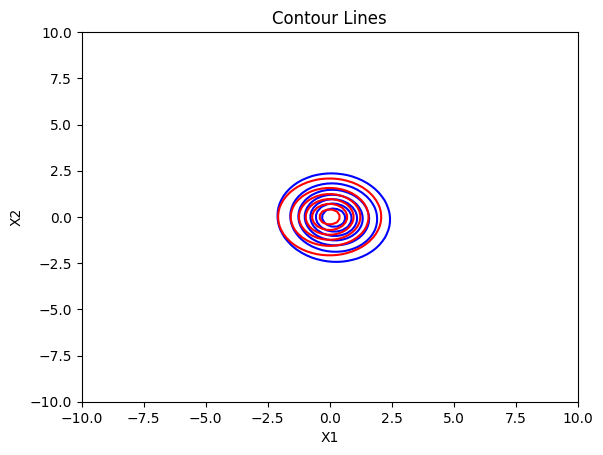

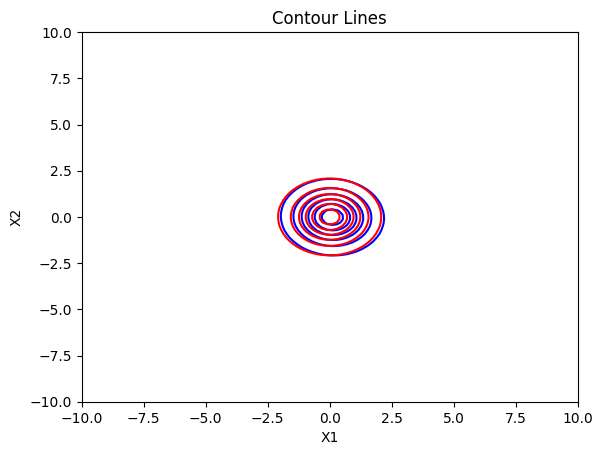

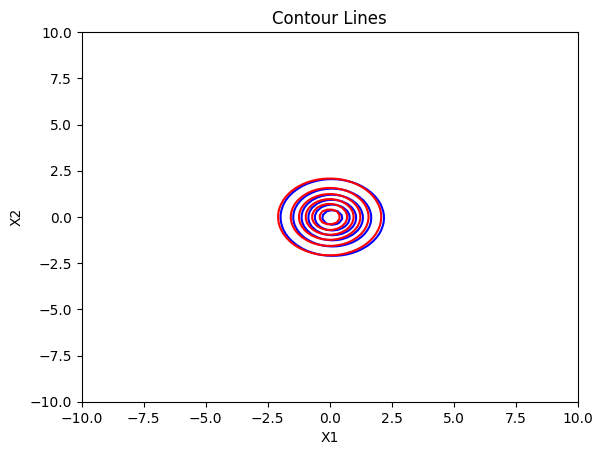

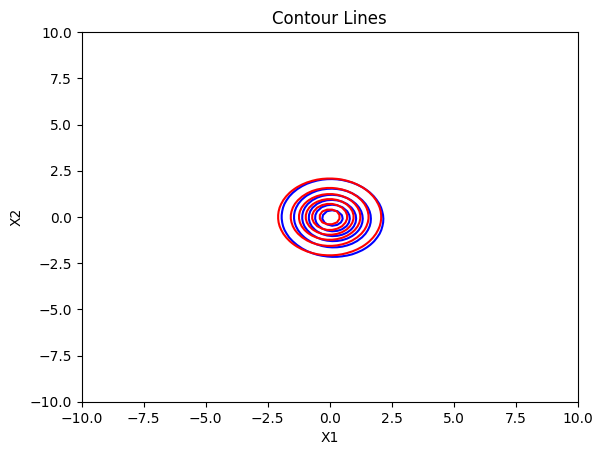

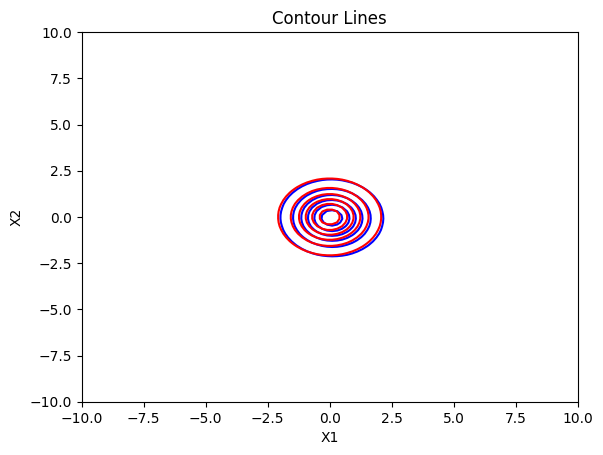

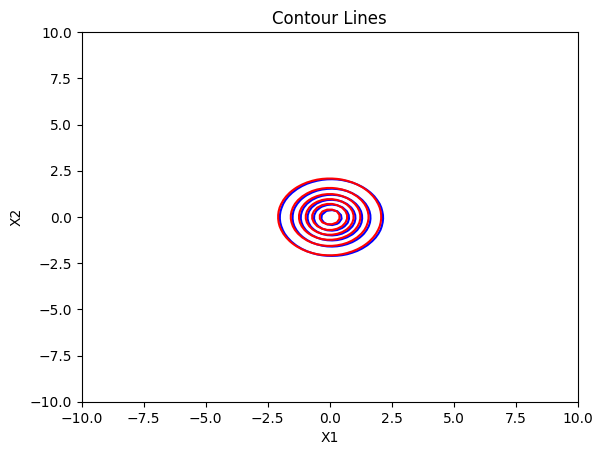

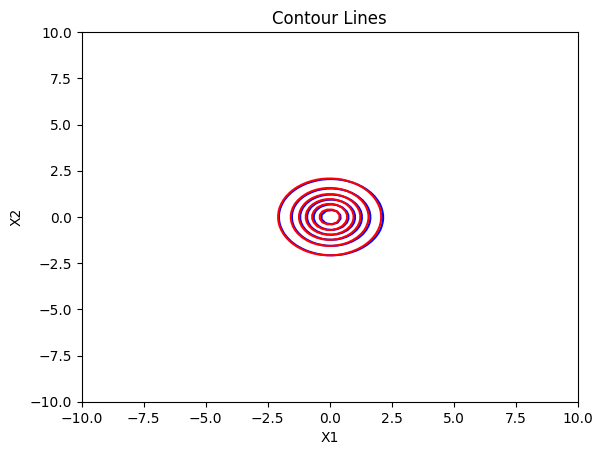

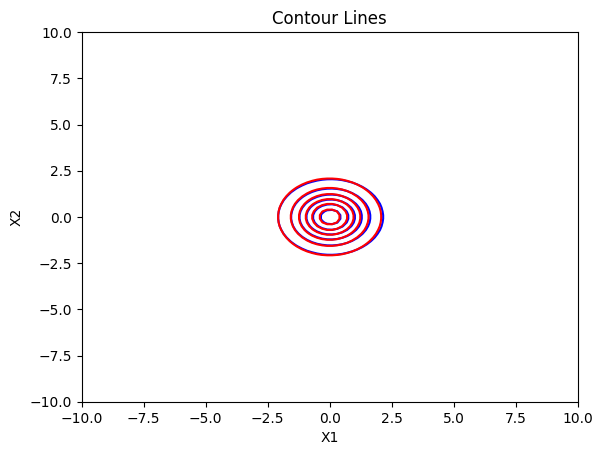

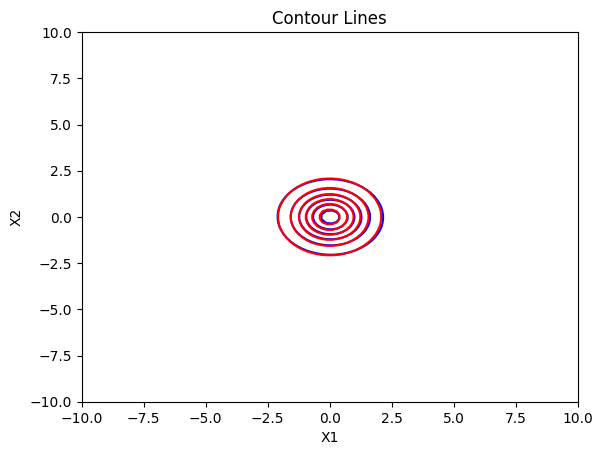

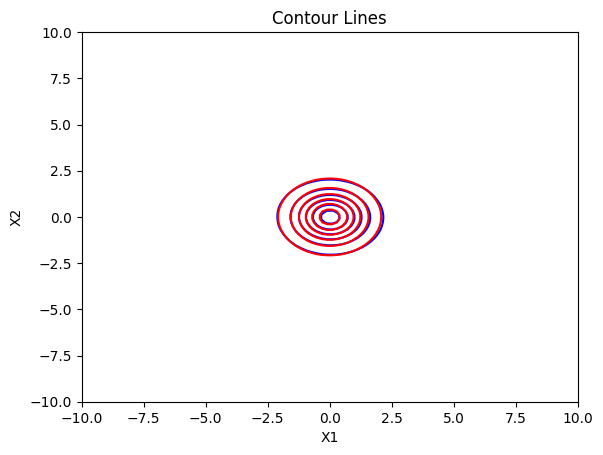

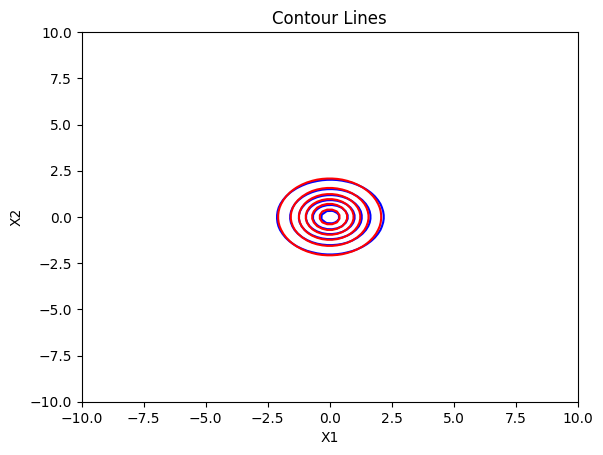

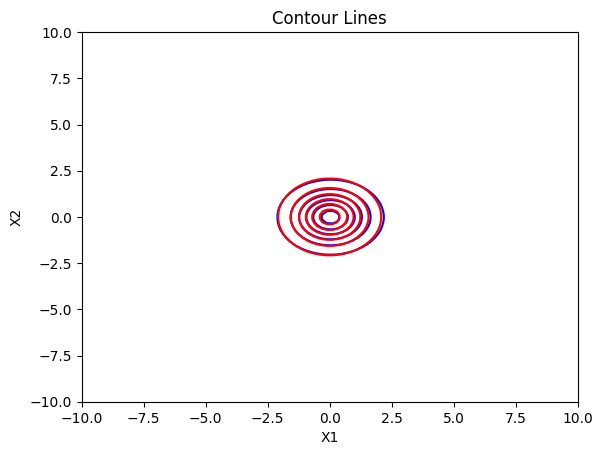

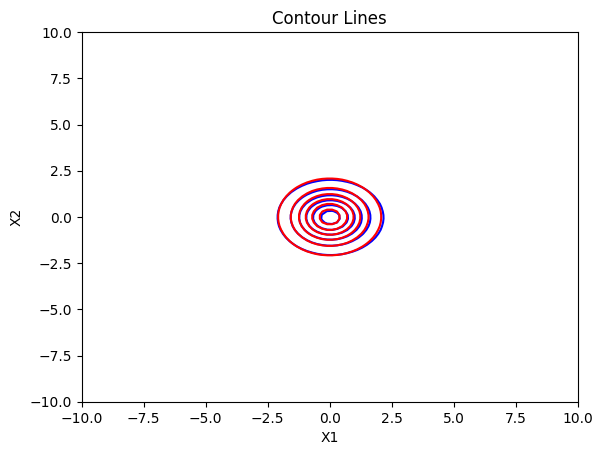

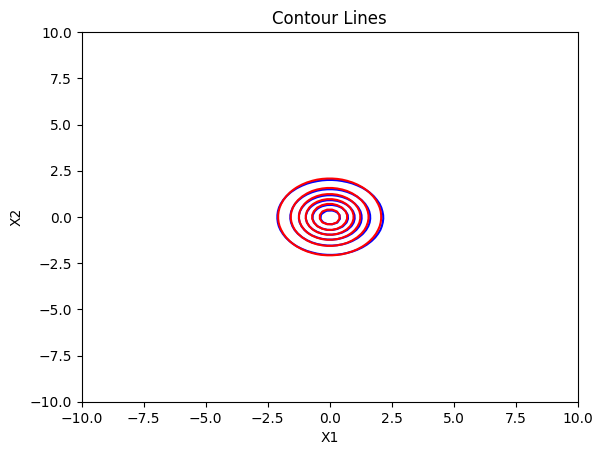

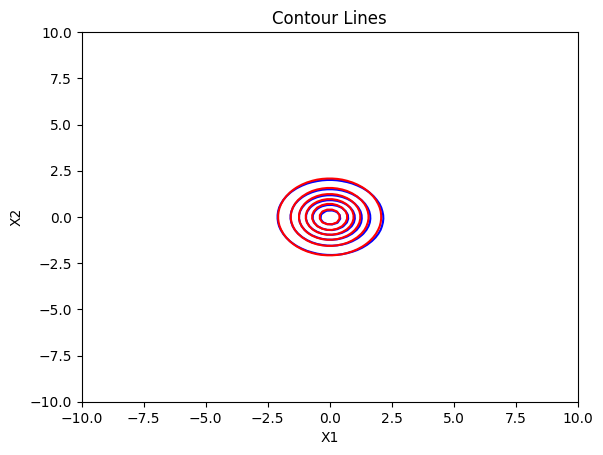

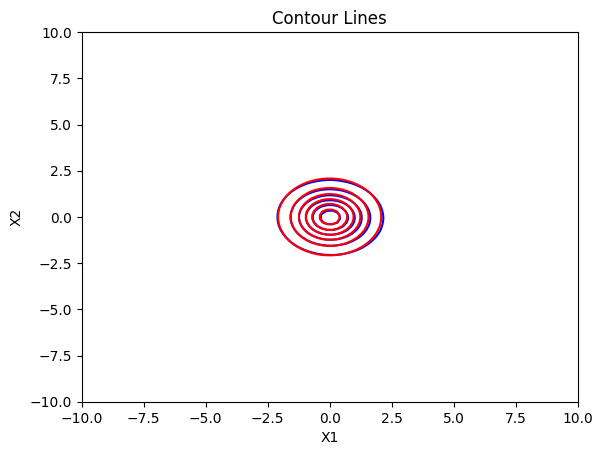

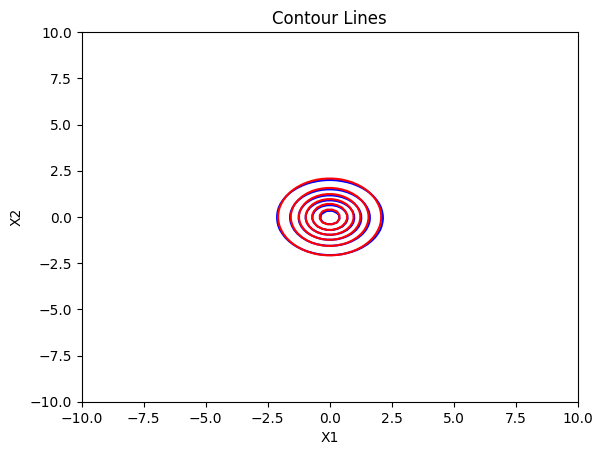

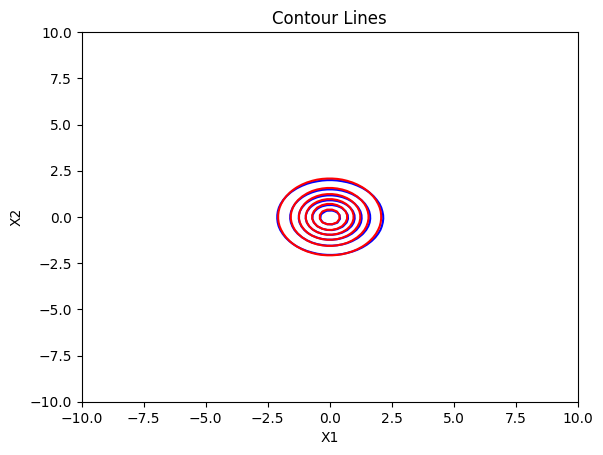

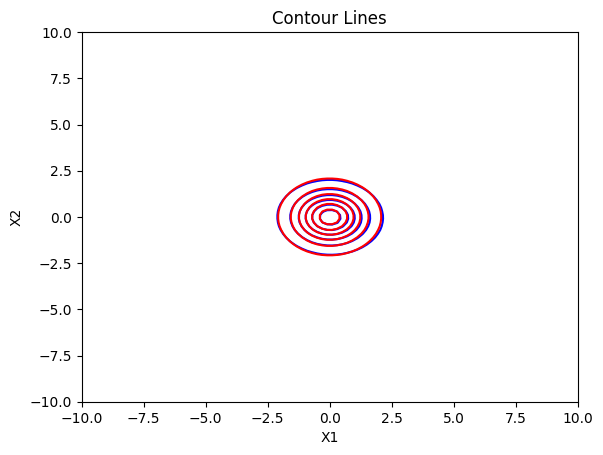

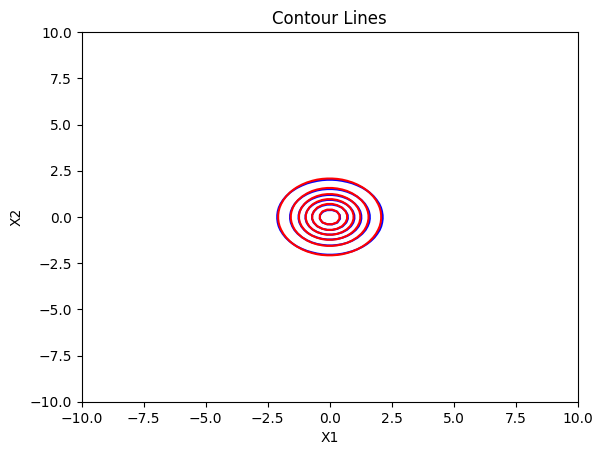

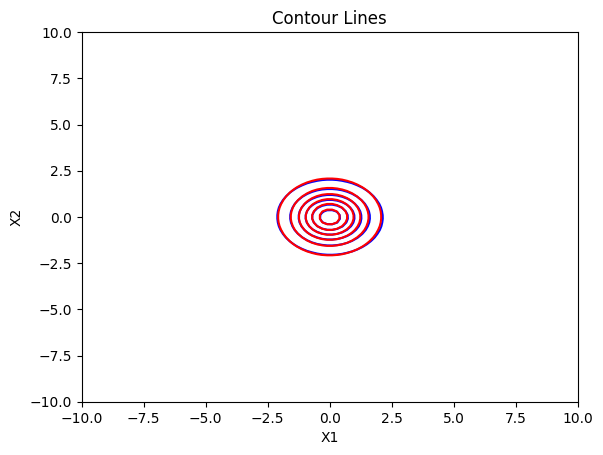

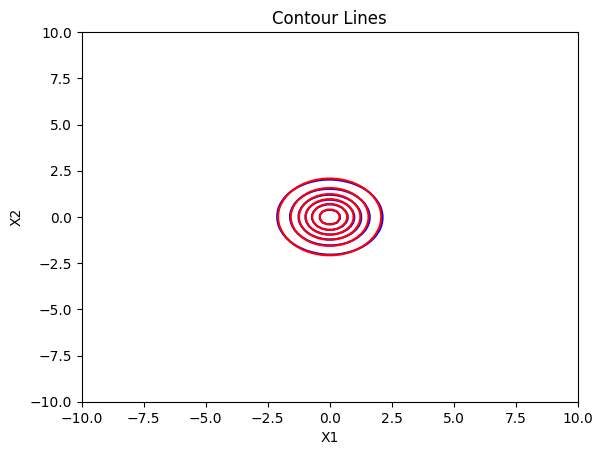

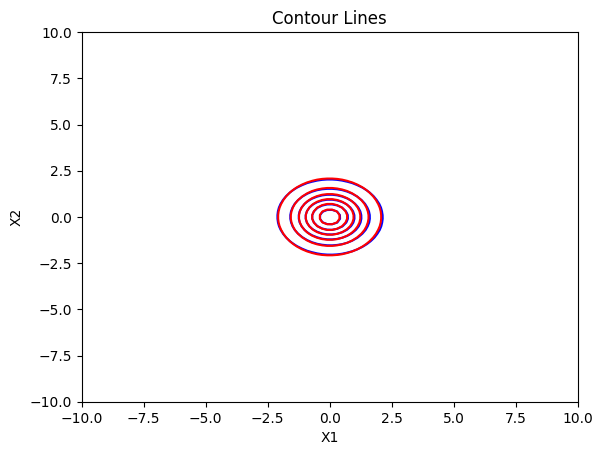

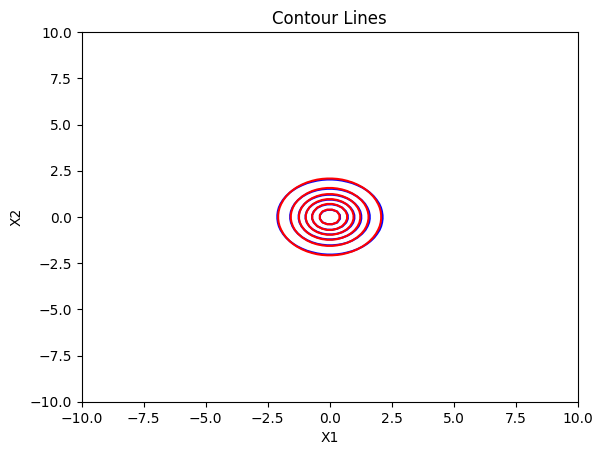

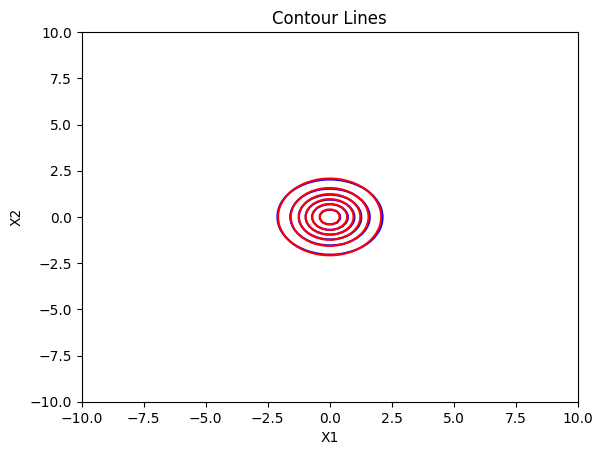

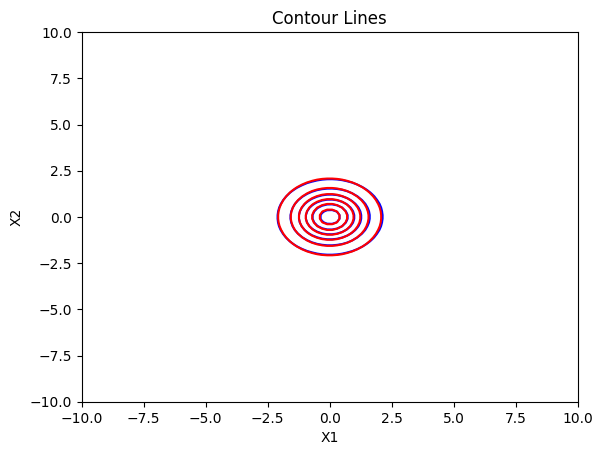

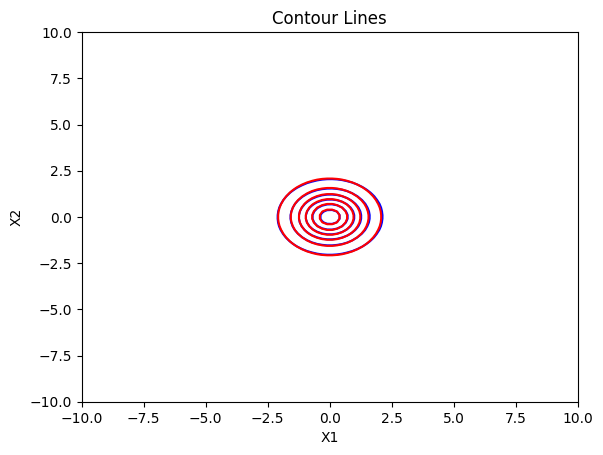

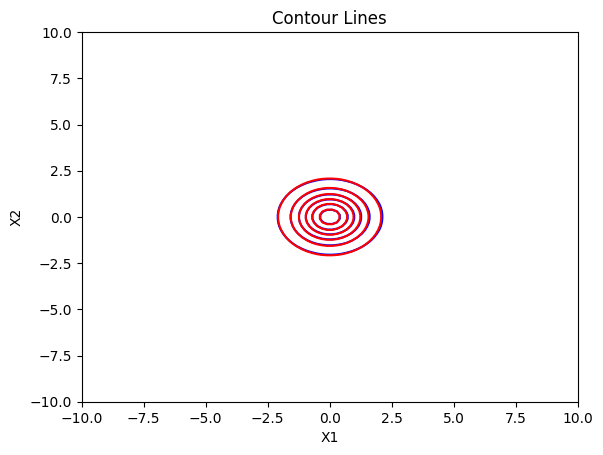

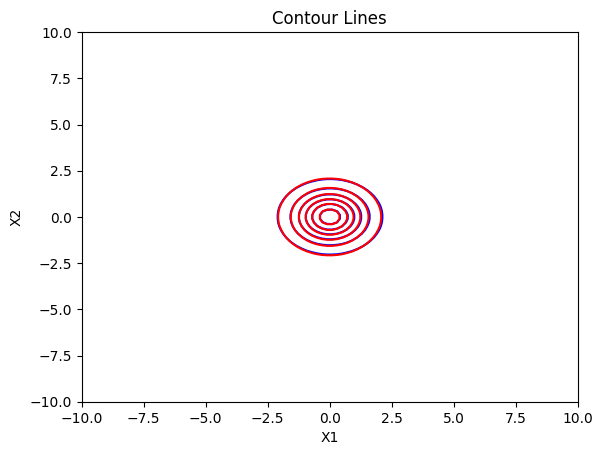

In [11]:
AMIS(mu_initial=mean_proposal,shape_initial=shape_proposal, n_iterations=30, target_pdf=multivariate_t(loc=mean_target,shape=shape_target,df=ddof_target), ddof_proposal=ddof_proposal)

In [ ]:
# Write movie to a file
filenames = [os.path.join("results", "ais-heavy-iter-{}.png".format(i)) for i in range(0,150)]

with imageio.get_writer(os.path.join("results", 'movie.gif'), mode='I', duration=0.3) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

clip = mp.VideoFileClip(os.path.join("results", 'movie.gif'))
clip.write_videofile(os.path.join("results", 'movie.mp4'))
# showing clip
# clip.ipython_display(width = 480)

